## **1. Next-Word Prediction using MLP [5 marks]**
In this question, you will extend the next-character prediction notebook (discussed in class) to a next-word prediction problem.That is you will create a MLP based text generator. You will train the model, visualize learned word embeddings, and finally deploy a Streamlit app for interactive text generation. It is recommended to refer to Andrej Karpathy’s blog post on the Effectiveness of RNNs.
You must complete this task for two datasets: one from Category I (Natural Language) and one from Category II (Structured/Domain Text).


###**1.1 Preprocessing and Vocabulary Construction [0.5 mark]**
For text-based datasets, you can remove special characters except “full stop (.)” so that it can be used to split sentences. However, you cannot ignore special characters for other datasets like for C++ code. You will have to treat text between newlines as a statement. To remove special characters from a line, you can use the following code snippet:
import re
line = re.sub('[^a-zA-Z0-9 \.]', '', line)
It will remove everything except alphanumeric characters, space and full-stop.
Convert the text to lowercase and use unique words to create the vocabulary.
• Report:
	- Vocabulary size
	- 10 most frequent and 10 least frequent words
To create X, and y pairs for training, you can use a similar approach used for next-character prediction.


#### Imports

In [ ]:
import torch
import re
from collections import Counter
import requests
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE


#### Set device


In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


#### Functions

In [ ]:
def preprocess_text(text, dataset_type='natural'):
    """
    Preprocess text based on dataset type
    """
    lines = text.split('\n')
    processed_lines = []

    for line in lines:
        if dataset_type == 'natural':
            # For natural language: remove special chars except period, lowercase
            line = re.sub(r'[^a-zA-Z0-9 \.]', '', line)


            line = line.lower()
        else:
            # For structured/domain text (like code): keep most characters but clean up
            line = re.sub(r'\s+', ' ', line)  # Replace multiple whitespace with single space
            line = line.strip()

        if line:  # Only add non-empty lines
            processed_lines.append(line)

    return processed_lines

def build_vocabulary(lines, dataset_type='natural'):
    """
    Build vocabulary from processed lines
    """
    word_counter = Counter()

    for line in lines:
        if dataset_type == 'natural':
            # Split by spaces for natural language
            words = line.split()
        else:
            # For structured text, we might want to split differently
            # Let's split by spaces but keep special characters together
            words = re.findall(r'\S+', line)

        word_counter.update(words)

    return word_counter

def create_vocab_mappings(word_counter, min_freq=1):
    """
    Create string-to-index and index-to-string mappings
    """
    # Filter words by minimum frequency
    filtered_words = {word: count for word, count in word_counter.items() if count >= min_freq}

    # Create vocabulary sorted by frequency (most frequent first)
    vocab = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)
    words_sorted = [word for word, count in vocab]

    # Add special tokens if needed
    stoi = {word: i+1 for i, word in enumerate(words_sorted)}  # Start from 1, 0 can be for padding
    itos = {i+1: word for i, word in enumerate(words_sorted)}

    # Add unknown token at index 0
    stoi['<UNK>'] = 0
    itos[0] = '<UNK>'

    return stoi, itos, filtered_words

# Prepare data for training (X, y pairs) - demonstration
def create_training_pairs(lines, stoi, block_size=5):
    """
    Create X, y training pairs for next-word prediction
    """
    X, Y = [], []

    for line in lines:
        if 'natural' in str(type(lines)):  # Natural language
            words = line.split()
        else:  # Structured text
            words = re.findall(r'\S+', line)

        if len(words) < 2:  # Skip very short sequences
            continue

        # Initialize context with padding (0 represents unknown/padding)
        context = [0] * block_size

        for word in words + ['.']:  # Add period as end-of-sequence marker
            ix = stoi.get(word, 0)  # Use 0 for unknown words

            X.append(context.copy())
            Y.append(ix)

            # Update context for next iteration
            context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)


#### 1st category

In [ ]:
# Download and process Category I: Natural Language (Sherlock Holmes)
print("Processing Category I: Natural Language (Sherlock Holmes)")
url1 = "https://www.gutenberg.org/files/1661/1661-0.txt"
response1 = requests.get(url1)
text1 = response1.text

# Remove Gutenberg header and footer
start_marker = "ADVENTURE I. A SCANDAL IN BOHEMIA"
end_marker = "End of the Project Gutenberg EBook"
start_idx = text1.find(start_marker)
end_idx = text1.find(end_marker)

if start_idx != -1 and end_idx != -1:
    text1 = text1[start_idx:end_idx]

lines1 = preprocess_text(text1, 'natural')
word_counter1 = build_vocabulary(lines1, 'natural')
stoi1, itos1, filtered_words1 = create_vocab_mappings(word_counter1)

print("\n=== Category I: Natural Language ===")
print(f"Vocabulary size: {len(stoi1)}")
print(f"Total words in corpus: {sum(word_counter1.values())}")

# Get most frequent and least frequent words
most_frequent = list(word_counter1.most_common(10))
least_frequent = list(word_counter1.most_common())[-10:]

print("\n10 most frequent words:")
for word, count in most_frequent:
    print(f"  {word}: {count}")

print("\n10 least frequent words:")
for word, count in least_frequent:
    print(f"  {word}: {count}")

Processing Category I: Natural Language (Sherlock Holmes)

=== Category I: Natural Language ===
Vocabulary size: 10490
Total words in corpus: 107510

10 most frequent words:
  the: 5811
  and: 3066
  i: 2966
  of: 2774
  to: 2753
  a: 2679
  in: 1805
  that: 1727
  it: 1561
  you: 1452

10 least frequent words:
  network: 1
  support.: 1
  included.: 1
  necessarily: 1
  edition.: 1
  pg: 1
  includes: 1
  subscribe: 1
  newsletter: 1
  ebooks.: 1


In [ ]:
import json
import os

# Make sure checkpoints folder exists
os.makedirs("checkpoints", exist_ok=True)

# Save vocabulary mappings
with open("checkpoints/stoi.json", "w") as f:
    json.dump(stoi1, f)

with open("checkpoints/itos.json", "w") as f:
    json.dump(itos1, f)


#### 2nd category


In [ ]:

# Download and process Category II: Structured/Domain Text (Linux source code)
print("\n" + "="*50)
print("Processing Category II: Structured Text (Linux Source Code)")
url2 = "https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt"
response2 = requests.get(url2)
text2 = response2.text

lines2 = preprocess_text(text2, 'structured')
word_counter2 = build_vocabulary(lines2, 'structured')
stoi2, itos2, filtered_words2 = create_vocab_mappings(word_counter2)

print("\n=== Category II: Structured Text ===")
print(f"Vocabulary size: {len(stoi2)}")
print(f"Total words in corpus: {sum(word_counter2.values())}")

# Get most frequent and least frequent words
most_frequent2 = list(word_counter2.most_common(10))
least_frequent2 = list(word_counter2.most_common())[-10:]

print("\n10 most frequent words:")
for word, count in most_frequent2:
    print(f"  {word}: {count}")

print("\n10 least frequent words:")
for word, count in least_frequent2:
    print(f"  {word}: {count}")



Processing Category II: Structured Text (Linux Source Code)

=== Category II: Structured Text ===
Vocabulary size: 113645
Total words in corpus: 759639

10 most frequent words:
  *: 33504
  =: 28003
  {: 18915
  if: 17702
  }: 16965
  the: 16080
  */: 13445
  /*: 12190
  struct: 10997
  return: 10130

10 least frequent words:
  NOKPROBE_SYMBOL(context_tracking_user_exit);: 1
  __context_tracking_task_switch: 1
  user-kernel: 1
  syscalls.: 1
  TIF: 1
  __context_tracking_task_switch(struct: 1
  clear_tsk_thread_flag(prev,: 1
  set_tsk_thread_flag(next,: 1
  CONFIG_CONTEXT_TRACKING_FORCE: 1
  context_tracking_init(void): 1


#### Creating Training pairs

In [ ]:
print("\n" + "="*50)
print("Training Data Preparation Summary")

# Create training pairs for both datasets
X1, Y1 = create_training_pairs(lines1, stoi1)  # Using first 100 lines for demo
X2, Y2 = create_training_pairs(lines2, stoi2)

print(f"Category I - Training pairs: {X1.shape[0]}")
print(f"Category II - Training pairs: {X2.shape[0]}")

# Display some examples
print("\nCategory I - Example training sequences:")
for i in range(3):
    context_words = [itos1.get(idx, '<UNK>') for idx in X1[i].tolist() if idx != 0]
    target_word = itos1.get(Y1[i].item(), '<UNK>')
    print(f"  Context: {context_words} -> Target: {target_word}")

print("\nCategory II - Example training sequences:")
for i in range(3):
    context_words = [itos2.get(idx, '<UNK>') for idx in X2[i].tolist() if idx != 0]
    target_word = itos2.get(Y2[i].item(), '<UNK>')
    print(f"  Context: {context_words} -> Target: {target_word}")


Training Data Preparation Summary
Category I - Training pairs: 116531
Category II - Training pairs: 833044

Category I - Example training sequences:
  Context: [] -> Target: the
  Context: ['the'] -> Target: project
  Context: ['the', 'project'] -> Target: gutenberg

Category II - Example training sequences:
  Context: [] -> Target: *
  Context: ['*'] -> Target: linux/kernel/irq/autoprobe.c
  Context: ['*', 'linux/kernel/irq/autoprobe.c'] -> Target: .


### **1.2 Model Design and Training [1 marks]**
Build an MLP-based text generator with the following structure:
- Embedding dimension: 32 or 64
- Hidden layers: 1–2 (1024 neurons each)
- Activation: ReLU or Tanh
- Output: Softmax over vocabulary

Use Google Colab or Kaggle for training (use maximum 500-1000 epochs). Start the assignment early, as training takes time.

 Report in notebook:
- Training vs validation loss plot
- Final validation loss/accuracy
- Example predictions and commentary on learning behavior.


#### Model architechture

In [ ]:
class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=1024, block_size=5, num_layers=2):
        super(NextWordMLP, self).__init__()
        self.block_size = block_size
        self.embedding_dim = embedding_dim

        # Embedding layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # MLP layers
        layers = []
        input_size = block_size * embedding_dim

        for i in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            input_size = hidden_dim

        layers.append(nn.Linear(hidden_dim, vocab_size))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, block_size)
        embeds = self.embeddings(x)  # (batch_size, block_size, embedding_dim)
        embeds = embeds.view(embeds.size(0), -1)  # Flatten: (batch_size, block_size * embedding_dim)
        output = self.mlp(embeds)
        return output


#### Training function

In [ ]:
def train_model_fixed_checkpoints(model, X_train, Y_train, X_val, Y_val, model_name):
    """Train with fixed epoch checkpoints + early stopping"""
    model.to(device)

    train_dataset = TensorDataset(X_train, Y_train)
    val_dataset = TensorDataset(X_val, Y_val)

    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # <-- L2 reg (helps generalization)

    train_losses = []
    val_losses = []
    val_accuracies = []

    import os
    os.makedirs('checkpoints', exist_ok=True)

    print("Training with fixed checkpoint epochs...")

    if model_name == "category1_natural":
        checkpoint_epochs = {'underfit': 1, 'optimal': 3, 'overfit': 10}
    else:
        checkpoint_epochs = {'underfit': 1, 'optimal': 3, 'overfit': 6}

    # --- Early stopping parameters ---
    best_val_loss = float('inf')
    patience = 3  # stop if no improvement for 3 epochs
    patience_counter = 0

    for epoch in range(max(checkpoint_epochs.values())):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += Y_batch.size(0)
                correct += (predicted == Y_batch).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(accuracy)

        current_epoch = epoch + 1

        # Save at fixed epochs
        for ckpt_type, ckpt_epoch in checkpoint_epochs.items():
            if current_epoch == ckpt_epoch:
                torch.save(model.state_dict(), f'checkpoints/{model_name}_{ckpt_type}_epoch_{current_epoch}.pth')
                print(f"{ckpt_type.upper()} checkpoint saved at epoch {current_epoch}")
                print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")

        # --- EARLY STOPPING LOGIC ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {current_epoch}")
                break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{current_epoch}/{max(checkpoint_epochs.values())}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies


#### Plotting function

In [ ]:
def plot_training_curves(train_losses, val_losses, val_accuracies, dataset_name):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title(f'{dataset_name} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curve
    ax2.plot(val_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title(f'{dataset_name} - Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


#### Testing and Text Generation

In [ ]:
def generate_text(model, stoi, itos, context_words, block_size=5, max_length=20):
    """Generate text given a context"""
    model.eval()
    generated = context_words.copy()

    # Convert initial context to indices
    context = [stoi.get(word, 0) for word in context_words]
    if len(context) < block_size:
        context = [0] * (block_size - len(context)) + context

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([context]).to(device)
            output = model(x)
            probabilities = torch.softmax(output, dim=1)

            # Sample from the probability distribution
            next_idx = torch.multinomial(probabilities, 1).item()
            next_word = itos.get(next_idx, '<UNK>')

            if next_word == '.':
                generated.append(next_word)
                break

            generated.append(next_word)
            context = context[1:] + [next_idx]

    return ' '.join(generated)


#### Preparing dataset

In [ ]:
def prepare_datasets(lines, stoi, train_ratio=0.8):
    """Prepare training and validation datasets"""
    X, Y = create_training_pairs(lines, stoi, block_size=5)

    # Split into train and validation
    split_idx = int(len(X) * train_ratio)
    X_train, X_val = X[:split_idx], X[split_idx:]
    Y_train, Y_val = Y[:split_idx], Y[split_idx:]

    return X_train, Y_train, X_val, Y_val

#### Category I

##### Preparing Data


In [ ]:
# Prepare Category I data - using more lines for better training
X1_train, Y1_train, X1_val, Y1_val = prepare_datasets(lines1, stoi1)

print(f"Training samples: {len(X1_train)}")
print(f"Validation samples: {len(X1_val)}")


Training samples: 93224
Validation samples: 23307


##### Training data

In [ ]:
# Initialize Category I model
model1 = NextWordMLP(vocab_size=len(stoi1), embedding_dim=64, hidden_dim=1024, num_layers=2)
print(f"Category I Model parameters: {sum(p.numel() for p in model1.parameters()):,}")

# Train with smart checkpointing
# For Category I
train_losses1, val_losses1, val_accuracies1 = train_model_fixed_checkpoints(
    model1, X1_train, Y1_train, X1_val, Y1_val, "category1_natural"
)

Category I Model parameters: 12,801,914
Training with fixed checkpoint epochs...
UNDERFIT checkpoint saved at epoch 1
  Train Loss: 6.3768, Val Loss: 6.2359, Val Acc: 11.18%
OPTIMAL checkpoint saved at epoch 3
  Train Loss: 5.3986, Val Loss: 6.0023, Val Acc: 12.69%
Early stopping triggered at epoch 7


##### Plots

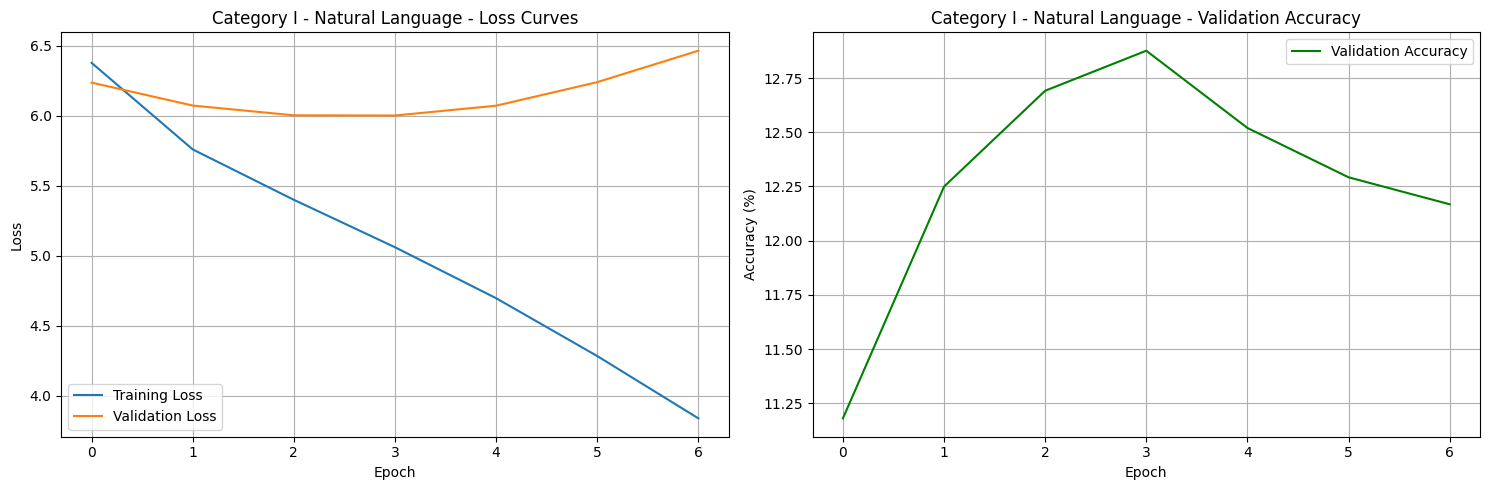

In [ ]:
# Plot results for Category I
plot_training_curves(train_losses1, val_losses1, val_accuracies1, "Category I - Natural Language")

#### Category II

##### Prepare data

In [ ]:
# Prepare Category II data
X2_train, Y2_train, X2_val, Y2_val = prepare_datasets(lines2, stoi2)

print(f"Training samples: {len(X2_train)}")
print(f"Validation samples: {len(X2_val)}")


Training samples: 666435
Validation samples: 166609


##### Training

In [ ]:
# Initialize Category II model
model2 = NextWordMLP(vocab_size=len(stoi2), embedding_dim=64, hidden_dim=1024, num_layers=2)
print(f"Category II Model parameters: {sum(p.numel() for p in model2.parameters()):,}")

# Train with smart checkpointing
train_losses2, val_losses2, val_accuracies2 = train_model_fixed_checkpoints(
    model2, X2_train, Y2_train, X2_val, Y2_val, "category2_structured"
)


Category II Model parameters: 125,137,709
Training with fixed checkpoint epochs...
UNDERFIT checkpoint saved at epoch 1
  Train Loss: 6.0083, Val Loss: 5.8543, Val Acc: 28.84%
OPTIMAL checkpoint saved at epoch 3
  Train Loss: 4.7406, Val Loss: 5.7339, Val Acc: 30.37%
OVERFIT checkpoint saved at epoch 6
  Train Loss: 3.9751, Val Loss: 5.8424, Val Acc: 30.92%


##### Plots

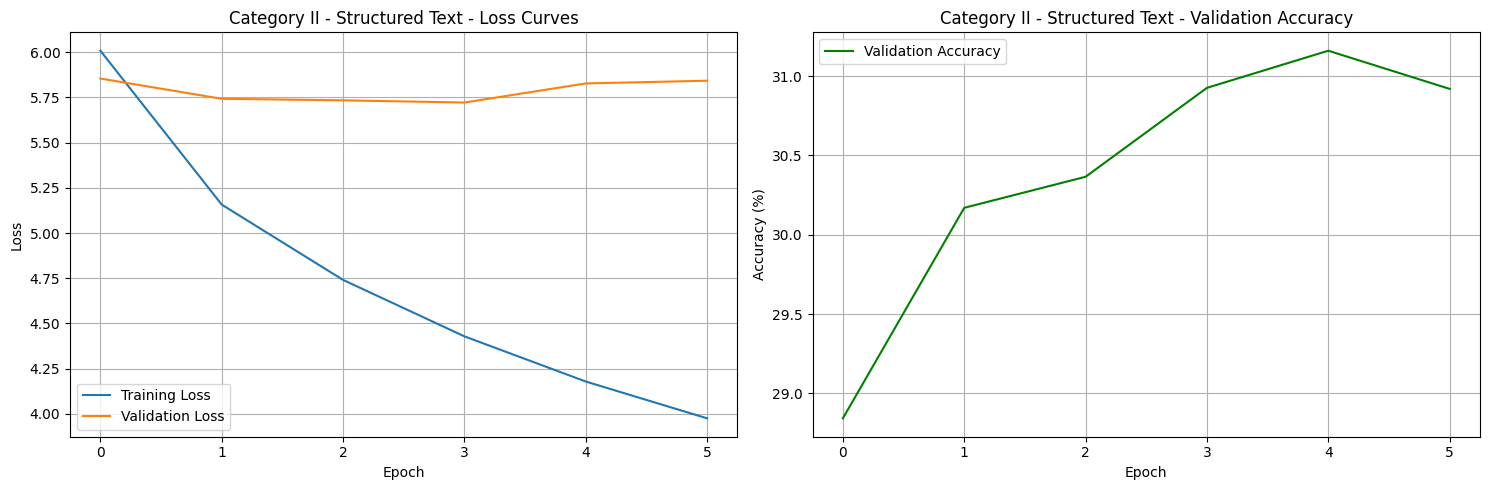


Final Category II Results:
Final Validation Loss: 5.8424
Final Validation Accuracy: 30.92%

Category II - Example Predictions:
Context: static void main string        -> Generated: static void main string .
Context: if config snd hda              -> Generated: if config snd hda u32 max_text_len = val3, .
Context: struct device * dev            -> Generated: struct device * dev = cycle_interval .
Context: int result = 0                 -> Generated: int result = 0 - 1; .
Context: for i = 0                      -> Generated: for i = 0 - can_boost; /* CPU p is mem_zone_bm_rtree. as the timer in any -1). .


In [ ]:

# Plot results for Category II
plot_training_curves(train_losses2, val_losses2, val_accuracies2, "Category II - Structured Text")


print(f"\nFinal Category II Results:")
print(f"Final Validation Loss: {val_losses2[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies2[-1]:.2f}%")

print("\nCategory II - Example Predictions:")
test_contexts2 = [
    ['static', 'void', 'main', 'string'],
    ['if', 'config', 'snd', 'hda'],
    ['struct', 'device', '*', 'dev'],
    ['int', 'result', '=', '0'],
    ['for', 'i', '=', '0']
]

for context in test_contexts2:
    generated = generate_text(model2, stoi2, itos2, context)
    print(f"Context: {' '.join(context):<30} -> Generated: {generated}")




#### Compare models

In [ ]:
def compare_checkpoint_models(model_class, stoi, itos, model_name, vocab_size):
    """Compare underfit, optimal, and overfit models"""
    print(f"\n{model_name} - COMPARING CHECKPOINTS:")
    print("=" * 50)

    test_contexts = [
        ['the', 'man', 'was', 'very'],
        ['sherlock', 'holmes', 'took', 'his'],
        ['it', 'was', 'a', 'dark']
    ] if 'natural' in model_name else [
        ['static', 'void', 'main', 'string'],
        ['if', 'config', 'snd', 'hda'],
        ['struct', 'device', '*', 'dev']
    ]

    checkpoint_types = ['underfit', 'optimal', 'overfit']

    for ckpt_type in checkpoint_types:
        checkpoint_path = f'checkpoints/{model_name}_{ckpt_type}_*.pth'
        import glob
        files = glob.glob(checkpoint_path)

        if files:
            # Load the model
            model = model_class(vocab_size=vocab_size)
            model.load_state_dict(torch.load(files[0], map_location=device))
            model.to(device)
            model.eval()

            print(f"\n{ckpt_type.upper()} MODEL:")
            print(f"Checkpoint: {files[0]}")

            # Generate text for each test context
            for i, context in enumerate(test_contexts[:2]):  # Show first 2 examples
                generated = generate_text(model, stoi, itos, context)
                print(f"  Context: {' '.join(context):<25} -> {generated}")
        else:
            print(f"\n{ckpt_type.upper()} MODEL: No checkpoint found")

# Compare all checkpoints for both models
compare_checkpoint_models(NextWordMLP, stoi1, itos1, "category1_natural", len(stoi1))
compare_checkpoint_models(NextWordMLP, stoi2, itos2, "category2_structured", len(stoi2))


category1_natural - COMPARING CHECKPOINTS:

UNDERFIT MODEL:
Checkpoint: checkpoints/category1_natural_underfit_epoch_1.pth
  Context: the man was very          -> the man was very schemer her man warmly. that now have been oclock the lately across found so <UNK> it was four your rooms
  Context: sherlock holmes took his  -> sherlock holmes took his first very me one observed heard presume name enough. the address face took indeed rushed into and lurid to as

OPTIMAL MODEL:
Checkpoint: checkpoints/category1_natural_optimal_epoch_2.pth
  Context: the man was very          -> the man was very to spinning before the mtier of some cry has we cant up these business acres afterwards your father. him the
  Context: sherlock holmes took his  -> sherlock holmes took his because get peep essential walks of entering from <UNK> the natural daughter in the hotel part i do <UNK> lover

OVERFIT MODEL:
Checkpoint: checkpoints/category1_natural_overfit_epoch_10.pth
  Context: the man was very          

#### Saving models

In [ ]:
# Save models for later use
torch.save(model1.state_dict(), 'category1_mlp_model.pth')
torch.save(model2.state_dict(), 'category2_mlp_model.pth')
print("\nModels saved for future use!")


Models saved for future use!


#### Visualise embeddings

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_embeddings(model, itos, selected_words=None, perplexity=30, random_state=42):
    """
    Visualize embeddings using t-SNE (if dim > 2) or scatter (if dim == 2)
    model: trained model containing 'embeddings' layer
    itos: index-to-string mapping
    selected_words: list of specific words to visualize
    """
    # Extract embedding weights
    weights = model.embeddings.weight.detach().cpu().numpy()
    emb_dim = weights.shape[1]

    # Filter only selected words if given
    if selected_words is not None:
        indices = [k for k, v in itos.items() if v in selected_words]
        labels = [itos[i] for i in indices]
        weights = weights[indices]
    else:
        # Otherwise visualize first N words
        N = min(200, len(itos))
        indices = list(range(N))
        labels = [itos[i] for i in indices]
        weights = weights[indices]

    # Adjust perplexity if needed
    n_samples = len(weights)
    if n_samples <= 2:
        raise ValueError("Need at least 3 words to visualize embeddings.")
    perplexity = min(perplexity, max(1, n_samples // 2))

    # Choose visualization method
    if emb_dim == 2:
        reduced = weights
        title = "Embedding Visualization (2D)"
    else:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
        reduced = tsne.fit_transform(weights)
        title = f"t-SNE Visualization of {emb_dim}D Embeddings (perplexity={perplexity})"

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1], color='gray', s=20, alpha=0.6)

    for i, label in enumerate(labels):
        plt.text(reduced[i, 0] + 0.02, reduced[i, 1] + 0.02, label, fontsize=9)

    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()


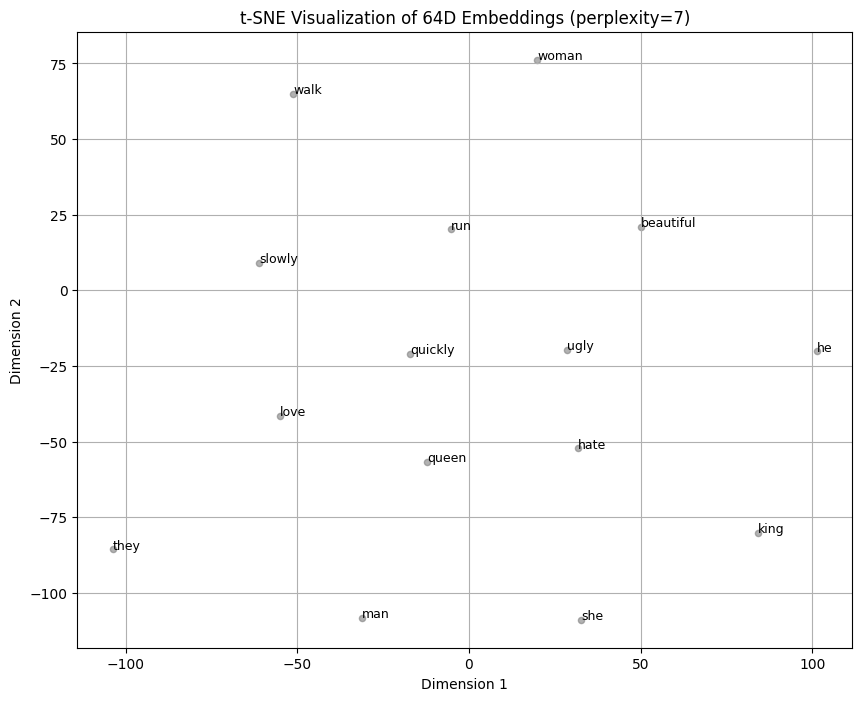

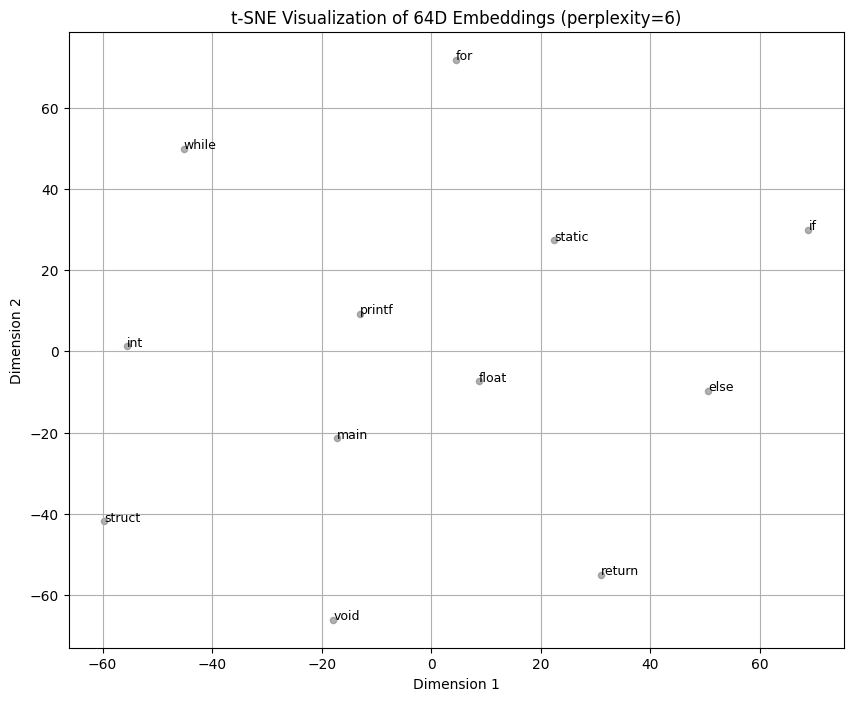

In [ ]:
# Visualize embeddings for Category I (Natural Language)
selected_natural = ['man', 'woman', 'king', 'queen', 'love', 'hate', 'beautiful', 'ugly',
                    'run', 'walk', 'quickly', 'slowly', 'he', 'she', 'they']

visualize_embeddings(model1, itos1, selected_words=selected_natural)

# Visualize embeddings for Category II (Structured Text)
selected_structured = ['int', 'float', 'if', 'else', 'while', 'return', 'for',
                       'struct', 'void', 'main', 'printf', 'static']

visualize_embeddings(model2, itos2, selected_words=selected_structured)
